### Assignment 4

In [1]:
import  torch
torch.__version__

'0.4.0'

### Load and prepare data

In [114]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

try:
    with np.load('./data/parsed.npz') as data:
        train_x = data['train_x']
        validation_x = data['validation_x']
        train_y = data['train_y']
        validation_y = data['validation_y']
        test_x = data['test_x']
except:
    with np.load('./data/prediction-challenge-02-data.npz') as fh:
        data_x = fh['data_x']
        data_y = fh['data_y']
        test_x = fh['test_x']
    
    data_x = np.rollaxis(data_x, 1, 4)
    test_x = np.rollaxis(test_x, 1, 4)
    print(data_x.shape)
    train_x, validation_x, train_y, validation_y = train_test_split(data_x, data_y, test_size=.2)
    print(validation_x.shape)
    
    zip = {
        'train_x': train_x,
        'validation_x': validation_x,
        'train_y': train_y, 
        'validation_y': validation_y,
        'test_x': test_x
    }
    np.savez('./data/parsed.npz', **zip)

### Let's visualize some data

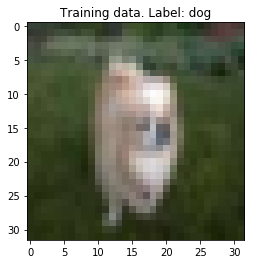

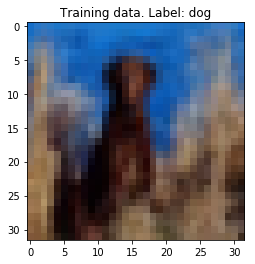

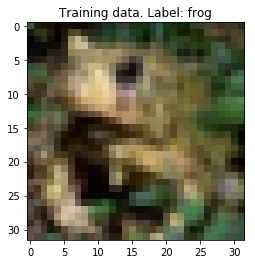

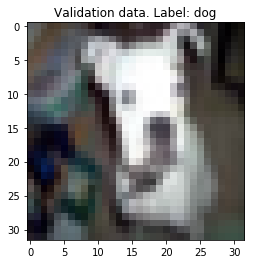

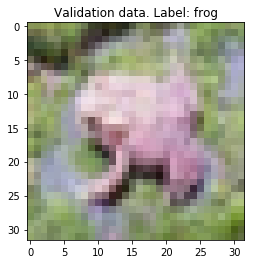

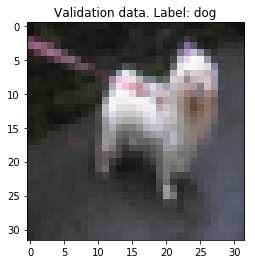

In [115]:
%matplotlib inline

labels = ['cat', 'dog', 'frog']

for i in range(3):
    plt.figure()
    plt.title('Training data. Label: {}'.format(labels[train_y[i]]))
    plt.imshow(train_x[i])
    
for i in range(3):
    plt.figure()
    plt.title('Validation data. Label: {}'.format(labels[validation_y[i]]))
    plt.imshow(validation_x[i])

### Normalize data

Here we are just calculating the mean value per channel (r,g,b) from the test data and subtracting this from each image in the dataset. 

In [116]:
per_channel_mean = np.mean(train_x, axis=0).mean(axis=0).mean(axis=0)
train_x -= per_channel_mean
validation_x -= per_channel_mean
test_x -= per_channel_mean

print('Per channel mean: {}'.format(per_channel_mean))
print('before: {}'.format(train_x[0][0][0]))
print('after: {}'.format(train_x[0][0][0] - per_channel_mean))

train_x = np.rollaxis(train_x, 3, 1)
test_x = np.rollaxis(test_x, 3, 1)
validation_x = np.rollaxis(validation_x, 3, 1)

Per channel mean: [ 0.48965949  0.45487654  0.39408451]
before: [-0.27789479 -0.19997457 -0.16663353]
after: [-0.76755428 -0.65485108 -0.56071806]
(1200, 32, 32, 3)
(1200, 3, 32, 32)
(300, 3, 32, 32)


### Transform data in pytorch format

In [140]:
import torch.utils.data as data_utils

kwargs  =  {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 16}

print(train_x.shape)

train_dataset = data_utils.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

(4800, 3, 32, 32)


## Build model

We are using "transfer-learning" here.

We get a pretrained 

In [216]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

KEEP_N_LAYERS = 5

class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.pretrained = models.squeezenet1_1(pretrained=True)
        
        self.pretrained.features = nn.Sequential(
            *(self.pretrained.features[i] for i in range(KEEP_N_LAYERS)))
        
        # shape is [128, 128, 7, 7] here
        conv1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.own = nn.Sequential(
            conv1,
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            conv2,
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128*7*7, 3)
        
        for param in self.pretrained.parameters():
            param.requires_grad = False
            
        
    def forward(self, x):
        for i in range(KEEP_N_LAYERS):
            x = self.pretrained.features[i](x)
        
        x = self.own(x)
        x = x.view(-1, 128*7*7)
        x = self.fc(x)
        
        return x

In [217]:
model = convNet()

if torch.cuda.is_available():
    model.cuda()

/home/hristov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/hristov/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [218]:
import  torch.optim as optim

optimizer = optim.Adam(model.own.parameters(), lr=0.01)

In [219]:
from torch.autograd import Variable

def train(epoch, callback):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        callback(batch_idx, output, target)
        
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [259]:
from decimal import *
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(validation_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct.item(), len(validation_loader.dataset),
        100. * correct.item() / len(validation_loader.dataset)))
    
    return Decimal((100. * correct.item()) / (1. * len(validation_loader.dataset))), test_loss

In [221]:
def  save_accuracy(i, output, target, save_in):
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()
    save_in.append(100. * correct / len(output))
    
def get_save_acc_in(save_in):
    return lambda x, y, z: save_accuracy(x, y, z, save_in)

In [223]:
%%time

per_batch_acc = []
epoch_acc = []
val_losses = []
best_acc = 0

for epoch in range(1, 20):
    train(epoch, get_save_acc_in(per_batch_acc))
    accuracy, val_loss = test()
    epoch_acc.append(accuracy)
    val_losses.append(val_loss)
    
    if best_acc < accuracy:
        best_acc = accuracy
        torch.save(model.state_dict(), './model')


/home/hristov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Train Epoch: 1 [128/4800 (3%)]	Loss: 0.471551
Train Epoch: 1 [256/4800 (5%)]	Loss: 0.455873
Train Epoch: 1 [384/4800 (8%)]	Loss: 0.487513
Train Epoch: 1 [512/4800 (11%)]	Loss: 0.476109
Train Epoch: 1 [640/4800 (13%)]	Loss: 0.444654
Train Epoch: 1 [768/4800 (16%)]	Loss: 0.511143
Train Epoch: 1 [896/4800 (18%)]	Loss: 0.527459
Train Epoch: 1 [1024/4800 (21%)]	Loss: 0.562248
Train Epoch: 1 [1152/4800 (24%)]	Loss: 0.523399
Train Epoch: 1 [1280/4800 (26%)]	Loss: 0.481510
Train Epoch: 1 [1408/4800 (29%)]	Loss: 0.622282
Train Epoch: 1 [1536/4800 (32%)]	Loss: 0.634456
Train Epoch: 1 [1664/4800 (34%)]	Loss: 0.531118
Train Epoch: 1 [1792/4800 (37%)]	Loss: 0.476833
Train Epoch: 1 [1920/4800 (39%)]	Loss: 0.530210
Train Epoch: 1 [2048/4800 (42%)]	Loss: 0.547966
Train Epoch: 1 [2176/4800 (45%)]	Loss: 0.483656
Train Epoch: 1 [2304/4800 (47%)]	Loss: 0.534459
Train Epoch: 1 [2432/4800 (50%)]	Loss: 0.462688
Train Epoch: 1 [2560/4800 (53%)]	Loss: 0.423451
Train Epoch: 1 [2688/4800 (55%)]	Loss: 0.483684
Tr

/home/hristov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()



Test set: Average loss: 0.5733, Accuracy: 889/1200 (74.000%)

Train Epoch: 2 [128/4800 (3%)]	Loss: 0.412787
Train Epoch: 2 [256/4800 (5%)]	Loss: 0.428794
Train Epoch: 2 [384/4800 (8%)]	Loss: 0.462723
Train Epoch: 2 [512/4800 (11%)]	Loss: 0.410774
Train Epoch: 2 [640/4800 (13%)]	Loss: 0.329243
Train Epoch: 2 [768/4800 (16%)]	Loss: 0.450438
Train Epoch: 2 [896/4800 (18%)]	Loss: 0.447699
Train Epoch: 2 [1024/4800 (21%)]	Loss: 0.451388
Train Epoch: 2 [1152/4800 (24%)]	Loss: 0.463415
Train Epoch: 2 [1280/4800 (26%)]	Loss: 0.481596
Train Epoch: 2 [1408/4800 (29%)]	Loss: 0.449428
Train Epoch: 2 [1536/4800 (32%)]	Loss: 0.465648
Train Epoch: 2 [1664/4800 (34%)]	Loss: 0.484438
Train Epoch: 2 [1792/4800 (37%)]	Loss: 0.428083
Train Epoch: 2 [1920/4800 (39%)]	Loss: 0.350064
Train Epoch: 2 [2048/4800 (42%)]	Loss: 0.447611
Train Epoch: 2 [2176/4800 (45%)]	Loss: 0.414255
Train Epoch: 2 [2304/4800 (47%)]	Loss: 0.435565
Train Epoch: 2 [2432/4800 (50%)]	Loss: 0.437573
Train Epoch: 2 [2560/4800 (53%)]	Lo

Train Epoch: 6 [1920/4800 (39%)]	Loss: 0.107492
Train Epoch: 6 [2048/4800 (42%)]	Loss: 0.118648
Train Epoch: 6 [2176/4800 (45%)]	Loss: 0.125614
Train Epoch: 6 [2304/4800 (47%)]	Loss: 0.156852
Train Epoch: 6 [2432/4800 (50%)]	Loss: 0.120815
Train Epoch: 6 [2560/4800 (53%)]	Loss: 0.156384
Train Epoch: 6 [2688/4800 (55%)]	Loss: 0.144749
Train Epoch: 6 [2816/4800 (58%)]	Loss: 0.135666
Train Epoch: 6 [2944/4800 (61%)]	Loss: 0.151700
Train Epoch: 6 [3072/4800 (63%)]	Loss: 0.161857
Train Epoch: 6 [3200/4800 (66%)]	Loss: 0.098221
Train Epoch: 6 [3328/4800 (68%)]	Loss: 0.151002
Train Epoch: 6 [3456/4800 (71%)]	Loss: 0.161951
Train Epoch: 6 [3584/4800 (74%)]	Loss: 0.157280
Train Epoch: 6 [3712/4800 (76%)]	Loss: 0.153043
Train Epoch: 6 [3840/4800 (79%)]	Loss: 0.158269
Train Epoch: 6 [3968/4800 (82%)]	Loss: 0.131334
Train Epoch: 6 [4096/4800 (84%)]	Loss: 0.133058
Train Epoch: 6 [4224/4800 (87%)]	Loss: 0.156770
Train Epoch: 6 [4352/4800 (89%)]	Loss: 0.112155
Train Epoch: 6 [4480/4800 (92%)]	Loss: 0

Train Epoch: 10 [3712/4800 (76%)]	Loss: 0.009900
Train Epoch: 10 [3840/4800 (79%)]	Loss: 0.012611
Train Epoch: 10 [3968/4800 (82%)]	Loss: 0.008806
Train Epoch: 10 [4096/4800 (84%)]	Loss: 0.016655
Train Epoch: 10 [4224/4800 (87%)]	Loss: 0.012754
Train Epoch: 10 [4352/4800 (89%)]	Loss: 0.012112
Train Epoch: 10 [4480/4800 (92%)]	Loss: 0.009879
Train Epoch: 10 [4608/4800 (95%)]	Loss: 0.012038
Train Epoch: 10 [4736/4800 (97%)]	Loss: 0.011270
Train Epoch: 10 [2432/4800 (100%)]	Loss: 0.011077

Test set: Average loss: 0.7390, Accuracy: 925/1200 (77.000%)

Train Epoch: 11 [128/4800 (3%)]	Loss: 0.006675
Train Epoch: 11 [256/4800 (5%)]	Loss: 0.005873
Train Epoch: 11 [384/4800 (8%)]	Loss: 0.008203
Train Epoch: 11 [512/4800 (11%)]	Loss: 0.007387
Train Epoch: 11 [640/4800 (13%)]	Loss: 0.012073
Train Epoch: 11 [768/4800 (16%)]	Loss: 0.004775
Train Epoch: 11 [896/4800 (18%)]	Loss: 0.006645
Train Epoch: 11 [1024/4800 (21%)]	Loss: 0.008651
Train Epoch: 11 [1152/4800 (24%)]	Loss: 0.005264
Train Epoch: 11

Train Epoch: 15 [128/4800 (3%)]	Loss: 0.001901
Train Epoch: 15 [256/4800 (5%)]	Loss: 0.001920
Train Epoch: 15 [384/4800 (8%)]	Loss: 0.001861
Train Epoch: 15 [512/4800 (11%)]	Loss: 0.002197
Train Epoch: 15 [640/4800 (13%)]	Loss: 0.002111
Train Epoch: 15 [768/4800 (16%)]	Loss: 0.002181
Train Epoch: 15 [896/4800 (18%)]	Loss: 0.001726
Train Epoch: 15 [1024/4800 (21%)]	Loss: 0.001874
Train Epoch: 15 [1152/4800 (24%)]	Loss: 0.001809
Train Epoch: 15 [1280/4800 (26%)]	Loss: 0.002082
Train Epoch: 15 [1408/4800 (29%)]	Loss: 0.002401
Train Epoch: 15 [1536/4800 (32%)]	Loss: 0.002145
Train Epoch: 15 [1664/4800 (34%)]	Loss: 0.002771
Train Epoch: 15 [1792/4800 (37%)]	Loss: 0.001894
Train Epoch: 15 [1920/4800 (39%)]	Loss: 0.001796
Train Epoch: 15 [2048/4800 (42%)]	Loss: 0.001820
Train Epoch: 15 [2176/4800 (45%)]	Loss: 0.002040
Train Epoch: 15 [2304/4800 (47%)]	Loss: 0.001679
Train Epoch: 15 [2432/4800 (50%)]	Loss: 0.002078
Train Epoch: 15 [2560/4800 (53%)]	Loss: 0.001858
Train Epoch: 15 [2688/4800 (55

Train Epoch: 19 [1536/4800 (32%)]	Loss: 0.001139
Train Epoch: 19 [1664/4800 (34%)]	Loss: 0.000946
Train Epoch: 19 [1792/4800 (37%)]	Loss: 0.001207
Train Epoch: 19 [1920/4800 (39%)]	Loss: 0.001137
Train Epoch: 19 [2048/4800 (42%)]	Loss: 0.001422
Train Epoch: 19 [2176/4800 (45%)]	Loss: 0.001459
Train Epoch: 19 [2304/4800 (47%)]	Loss: 0.001390
Train Epoch: 19 [2432/4800 (50%)]	Loss: 0.001149
Train Epoch: 19 [2560/4800 (53%)]	Loss: 0.001161
Train Epoch: 19 [2688/4800 (55%)]	Loss: 0.001030
Train Epoch: 19 [2816/4800 (58%)]	Loss: 0.001187
Train Epoch: 19 [2944/4800 (61%)]	Loss: 0.001268
Train Epoch: 19 [3072/4800 (63%)]	Loss: 0.001182
Train Epoch: 19 [3200/4800 (66%)]	Loss: 0.000909
Train Epoch: 19 [3328/4800 (68%)]	Loss: 0.000997
Train Epoch: 19 [3456/4800 (71%)]	Loss: 0.001211
Train Epoch: 19 [3584/4800 (74%)]	Loss: 0.001198
Train Epoch: 19 [3712/4800 (76%)]	Loss: 0.001096
Train Epoch: 19 [3840/4800 (79%)]	Loss: 0.001138
Train Epoch: 19 [3968/4800 (82%)]	Loss: 0.001214
Train Epoch: 19 [409

In [224]:
def plot_accuracy(accuracy_arr, title, xlabel='Number of batches seen'):
    ax = plt.gca()
    ax.plot(np.arange(len(accuracy_arr)), accuracy_arr)
    # could be more than the total number of batches because of epochs
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(np.arange(len(accuracy_arr)))
    plt.title(title)
    plt.show()
    np.arange(len(accuracy_arr))

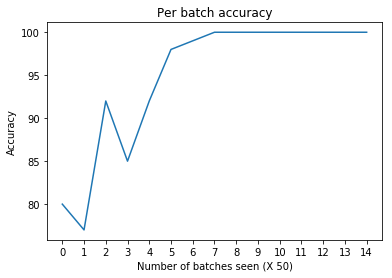

In [228]:
plot_accuracy(per_batch_acc[::50], 'Per batch accuracy', 'Number of batches seen (X 50)')

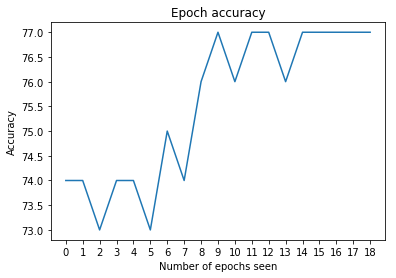

In [227]:
plot_accuracy(epoch_acc, 'Epoch accuracy', 'Number of epochs seen')

### Prediction for challenge

In [229]:
out = model(Variable(torch.from_numpy(test_x)))
_, prediction = torch.max(out, 1)
prediction = prediction.data.numpy()

(300, 3, 32, 32)
(32, 32, 3)


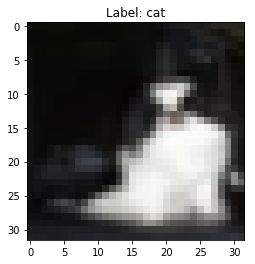

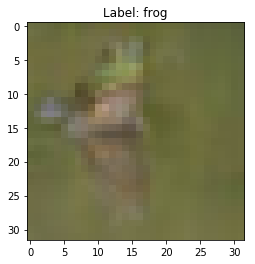

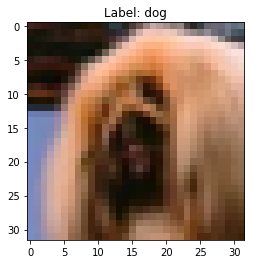

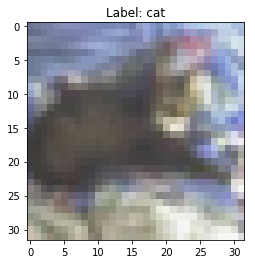

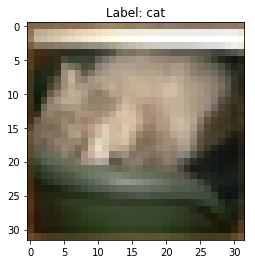

In [243]:
print(test_x.shape)
rolled = np.rollaxis(test_x, 1, 4)
print(rolled[0].shape)

for i in range(5):
    plt.figure()
    plt.imshow(rolled[i] + per_channel_mean)
    plt.title('Label: {}'.format(labels[prediction[i]]))

In [260]:
accuracy = test()[0]
print('Score: {0:.2f}'.format(accuracy))


Test set: Average loss: 0.8550, Accuracy: 933/1200 (77.750%)

Score: 77.75


In [245]:
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)